# Exploración del sueño recortado (Sleep-EDFx)
Esta notebook analiza la versión procesada del dataset, recortada al periodo de sueño con un buffer de vigilia previo y posterior.

## 1. Cargar manifiesto recortado
Verificamos que el preprocesamiento se haya ejecutado y cargamos el manifest con los caminos a los archivos recortados.

In [1]:
# Configuración y utilidades
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne

sns.set_theme(style="whitegrid", palette="deep")
PROJECT_ROOT = Path("..").resolve()
DATA_ROOT = PROJECT_ROOT / "data"
TRIM_ROOT = DATA_ROOT / "processed" / "sleep_trimmed"
TRIM_MANIFEST = DATA_ROOT / "processed" / "manifest_trimmed.csv"
TRIM_MANIFEST

PosixPath('/Users/ignacio/Repos/Sleep/data/processed/manifest_trimmed.csv')

In [2]:
if not TRIM_MANIFEST.exists():
    raise FileNotFoundError(
        "No se encontró el manifest recortado. Ejecutá `python src/preprocessing.py` con los parámetros deseados antes de continuar."
    )

trim_manifest = pd.read_csv(TRIM_MANIFEST)
trim_manifest.head()

,subject_id,subset,version,status,psg_trimmed_path,hypnogram_trimmed_path,trim_start_sec,trim_end_sec,trim_duration_sec,padding_pre_sec,padding_post_sec,notes
0,SC4201E,sleep-cassette,1.0.0,ok,data/processed/sleep_trimmed/psg/SC4201E_sleep...,data/processed/sleep_trimmed/hypnograms/SC4201...,21750.0,56040.0,34290.0,3600.0,3600.0,NaN
1,SC4141E,sleep-cassette,1.0.0,ok,data/processed/sleep_trimmed/psg/SC4141E_sleep...,data/processed/sleep_trimmed/hypnograms/SC4141...,21540.0,55260.0,33720.0,3600.0,3600.0,NaN
2,SC4171E,sleep-cassette,1.0.0,ok,data/processed/sleep_trimmed/psg/SC4171E_sleep...,data/processed/sleep_trimmed/hypnograms/SC4171...,25410.0,59100.0,33690.0,3600.0,3600.0,NaN
3,SC4272F,sleep-cassette,1.0.0,ok,data/processed/sleep_trimmed/psg/SC4272F_sleep...,data/processed/sleep_trimmed/hypnograms/SC4272...,36930.0,73230.0,36300.0,3600.0,3600.0,NaN
4,SC4041E,sleep-cassette,1.0.0,ok,data/processed/sleep_trimmed/psg/SC4041E_sleep...,data/processed/sleep_trimmed/hypnograms/SC4041...,20760.0,61440.0,40680.0,3600.0,3600.0,NaN


## 2. Resumen del manifest recortado
Exploramos cuántas sesiones se procesaron y verificamos la disponibilidad de archivos.

In [3]:
trim_manifest["status"].value_counts().rename_axis("status").reset_index(
    name="sessions"
)

,status,sessions
0,ok,73


In [4]:
trim_manifest[["psg_trimmed_path", "hypnogram_trimmed_path"]].apply(
    lambda col: col.notna().mean() * 100
).rename("coverage_%")

psg_trimmed_path          100.0
hypnogram_trimmed_path    100.0
Name: coverage_%, dtype: float64

## 3. Conversión de estadios
Utilizamos el mismo mapeo que en la libreta original para unificar las etiquetas del hipnograma y sumar duraciones por estadio.

In [5]:
STAGE_CANONICAL = {
    "Sleep stage W": "W",
    "Sleep stage 1": "N1",
    "Sleep stage 2": "N2",
    "Sleep stage 3": "N3",
    "Sleep stage 4": "N3",
    "Sleep stage R": "REM",
}
SLEEP_STAGES = {"N1", "N2", "N3", "REM"}


def load_trimmed_hypnogram(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    if df.empty:
        return pd.DataFrame(columns=["stage", "duration_sec"])
    df["stage"] = df["description"].map(STAGE_CANONICAL)
    df = df.dropna(subset=["stage"])
    df = df.rename(columns={"duration": "duration_sec"})
    return df.groupby("stage", as_index=False)["duration_sec"].sum()

In [6]:
stage_summaries = []
missing = []
for row in trim_manifest.itertuples():
    hyp_path = (
        Path(row.hypnogram_trimmed_path)
        if isinstance(row.hypnogram_trimmed_path, str)
        else None
    )
    if hyp_path and not hyp_path.is_absolute():
        hyp_path = PROJECT_ROOT / hyp_path
    if hyp_path and hyp_path.exists():
        df = load_trimmed_hypnogram(hyp_path)
        if not df.empty:
            df["subject_id"] = row.subject_id
            stage_summaries.append(df)
    else:
        missing.append(row.subject_id)
if missing:
    print(f"No se encontraron {len(missing)} hipnogramas recortados: {missing}")
if not stage_summaries:
    raise RuntimeError(
        "No hay estadísticas de sueño disponibles. Verificá la ejecución del preprocesamiento."
    )
stages_all = pd.concat(stage_summaries, ignore_index=True)
stages_all.head()

,stage,duration_sec,subject_id
0,N1,1170.0,SC4201E
1,N2,16170.0,SC4201E
2,N3,120.0,SC4201E
3,REM,5310.0,SC4201E
4,W,11490.0,SC4201E


## 4. Distribución agregada de estadios
Calculamos el mix de estadios agregados en el periodo recortado y lo comparamos con la versión cruda.

In [7]:
stage_totals = stages_all.groupby("stage", as_index=False)["duration_sec"].sum()
stage_totals["hours"] = stage_totals["duration_sec"] / 3600
stage_totals["percent"] = (
    100 * stage_totals["duration_sec"] / stage_totals["duration_sec"].sum()
)
stage_totals.sort_values("duration_sec", ascending=False)

,stage,duration_sec,hours,percent
1,N2,1009020.0,280.283333,36.595291
4,W,899220.0,249.783333,32.613048
3,REM,400980.0,111.383333,14.542804
2,N3,236400.0,65.666667,8.573791
0,N1,211620.0,58.783333,7.675066


/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_77137/2669716904.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=stage_totals.sort_values('percent', ascending=False), x='percent', y='stage', palette='mako')


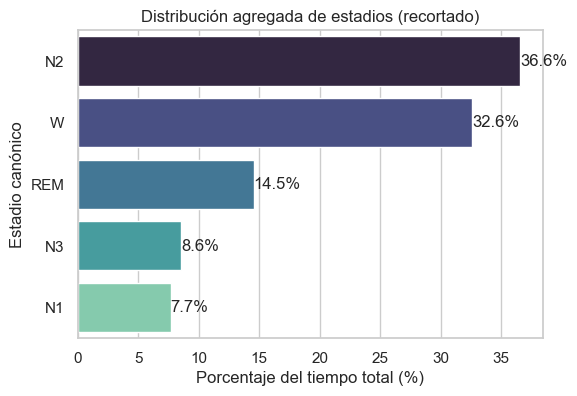

In [8]:
plt.figure(figsize=(6, 4))
sns.barplot(
    data=stage_totals.sort_values("percent", ascending=False),
    x="percent",
    y="stage",
    palette="mako",
)
plt.xlabel("Porcentaje del tiempo total (%)")
plt.ylabel("Estadio canónico")
plt.title("Distribución agregada de estadios (recortado)")
for container in plt.gca().containers:
    plt.bar_label(container, fmt="%.1f%%")
plt.show()

## 5. Variabilidad por sujeto
Analizamos el porcentaje de tiempo por estadio en cada sujeto dentro del periodo recortado.

In [9]:
subject_stage_share = stages_all.copy()
subject_stage_share["total_subject"] = subject_stage_share.groupby("subject_id")[
    "duration_sec"
].transform("sum")
subject_stage_share["percent"] = (
    100 * subject_stage_share["duration_sec"] / subject_stage_share["total_subject"]
)
subject_stage_share.head()

,stage,duration_sec,subject_id,total_subject,percent
0,N1,1170.0,SC4201E,34260.0,3.415061
1,N2,16170.0,SC4201E,34260.0,47.197898
2,N3,120.0,SC4201E,34260.0,0.350263
3,REM,5310.0,SC4201E,34260.0,15.499124
4,W,11490.0,SC4201E,34260.0,33.537653


/var/folders/6c/1g3b2t8s1l5ch_c9nch8gppw0000gn/T/ipykernel_77137/309456361.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subject_stage_share, x='stage', y='percent', palette='Set2')


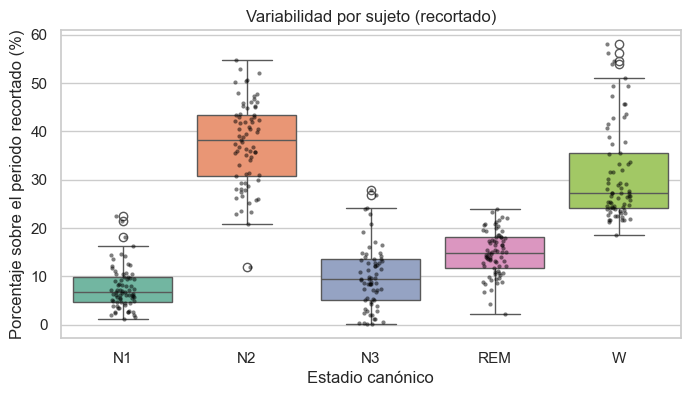

In [10]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=subject_stage_share, x="stage", y="percent", palette="Set2")
sns.stripplot(
    data=subject_stage_share, x="stage", y="percent", color="black", alpha=0.5, size=3
)
plt.ylabel("Porcentaje sobre el periodo recortado (%)")
plt.xlabel("Estadio canónico")
plt.title("Variabilidad por sujeto (recortado)")
plt.show()

## 6. Ejemplos de segmentos
Visualizamos segmentos típicos de cada estadio a partir de los PSG recortados.

In [11]:
DEFAULT_CHANNELS = ["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal", "EMG submental"]


def get_trimmed_paths(subject_id: str) -> tuple[Path, Path]:
    match = trim_manifest[
        (trim_manifest["subject_id"] == subject_id) & (trim_manifest["status"] == "ok")
    ]
    if match.empty:
        raise ValueError(f"No hay sesión recortada para {subject_id}")
    row = match.iloc[0]
    psg_path = Path(row["psg_trimmed_path"])
    hyp_path = Path(row["hypnogram_trimmed_path"])
    if not psg_path.is_absolute():
        psg_path = PROJECT_ROOT / psg_path
    if not hyp_path.is_absolute():
        hyp_path = PROJECT_ROOT / hyp_path
    return psg_path, hyp_path


def merge_stage_regions(hypnogram_path: Path, stage: str):
    df = pd.read_csv(hypnogram_path)
    df["stage"] = df["description"].map(STAGE_CANONICAL)
    df = df[df["stage"] == stage]
    regions = []
    current_start = None
    current_end = None
    for onset, duration in zip(df["onset"], df["duration"]):
        onset = float(onset)
        end = onset + float(duration)
        if current_start is None:
            current_start = onset
            current_end = end
        elif abs(onset - current_end) < 1e-6:
            current_end = end
        else:
            regions.append((current_start, current_end))
            current_start = onset
            current_end = end
    if current_start is not None:
        regions.append((current_start, current_end))
    return regions


def find_stage_window(hypnogram_path: Path, stage: str, duration: float = 120.0):
    regions = merge_stage_regions(hypnogram_path, stage)
    if not regions:
        return None
    regions.sort(key=lambda r: r[1] - r[0], reverse=True)
    longest_start, longest_end = regions[0]
    window_duration = longest_end - longest_start
    if window_duration <= 0:
        return None
    if window_duration >= duration:
        return longest_start, longest_start + duration
    return longest_start, longest_end


def extract_trimmed_segment(
    psg_path: Path, start: float, end: float, picks=None, resample: float | None = 100.0
):
    raw = mne.io.read_raw_fif(psg_path, preload=True, verbose="ERROR")
    available = raw.ch_names
    if picks is None:
        picks = [ch for ch in DEFAULT_CHANNELS if ch in available] or available
    raw.pick_channels(picks)
    if resample:
        raw.resample(resample)
    segment = raw.copy().crop(tmin=start, tmax=end)
    data = segment.get_data()
    times = segment.times
    return times, data, segment.ch_names


def plot_trimmed_segment(
    subject_id: str, stage: str, duration: float = 120.0, resample: float | None = 100.0
):
    psg_path, hyp_path = get_trimmed_paths(subject_id)
    if not psg_path.exists() or not hyp_path.exists():
        raise FileNotFoundError(
            f"No se encontraron archivos recortados para {subject_id}"
        )
    window = find_stage_window(hyp_path, stage, duration)
    if window is None:
        raise RuntimeError(
            f"No se encontró una ventana de {duration}s en estadio {stage} para {subject_id}"
        )
    start, end = window
    times, data, channels = extract_trimmed_segment(
        psg_path, start, end, resample=resample
    )
    fig, axes = plt.subplots(
        len(channels), 1, figsize=(14, 2.0 * len(channels)), sharex=True
    )
    if len(channels) == 1:
        axes = [axes]
    for idx, ax in enumerate(axes):
        ax.plot(times, data[idx])
        ax.set_ylabel(channels[idx])
        ax.grid(True, linestyle="--", alpha=0.3)
    axes[-1].set_xlabel("Tiempo (s)")
    fig.suptitle(f"{subject_id} | Estadio {stage} | {duration:.0f}s (datos recortados)")
    fig.tight_layout(rect=(0, 0, 1, 0.96))
    return fig

In [12]:
stage_targets = ["W", "N2", "N3", "REM"]
subjects_available = list(trim_manifest[trim_manifest["status"] == "ok"]["subject_id"])
if not subjects_available:
    raise RuntimeError("No hay sujetos recortados disponibles para ejemplos.")
example_plan = [
    (subjects_available[idx % len(subjects_available)], stage)
    for idx, stage in enumerate(stage_targets)
]
example_plan

[('SC4201E', 'W'), ('SC4141E', 'N2'), ('SC4171E', 'N3'), ('SC4272F', 'REM')]

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Sampling frequency of the instance is already 100.0, returning unmodified.


[('SC4201E', 'W', <Figure size 1400x800 with 4 Axes>),
 ('SC4141E', 'N2', <Figure size 1400x800 with 4 Axes>),
 ('SC4171E', 'N3', <Figure size 1400x800 with 4 Axes>),
 ('SC4272F', 'REM', <Figure size 1400x800 with 4 Axes>)]

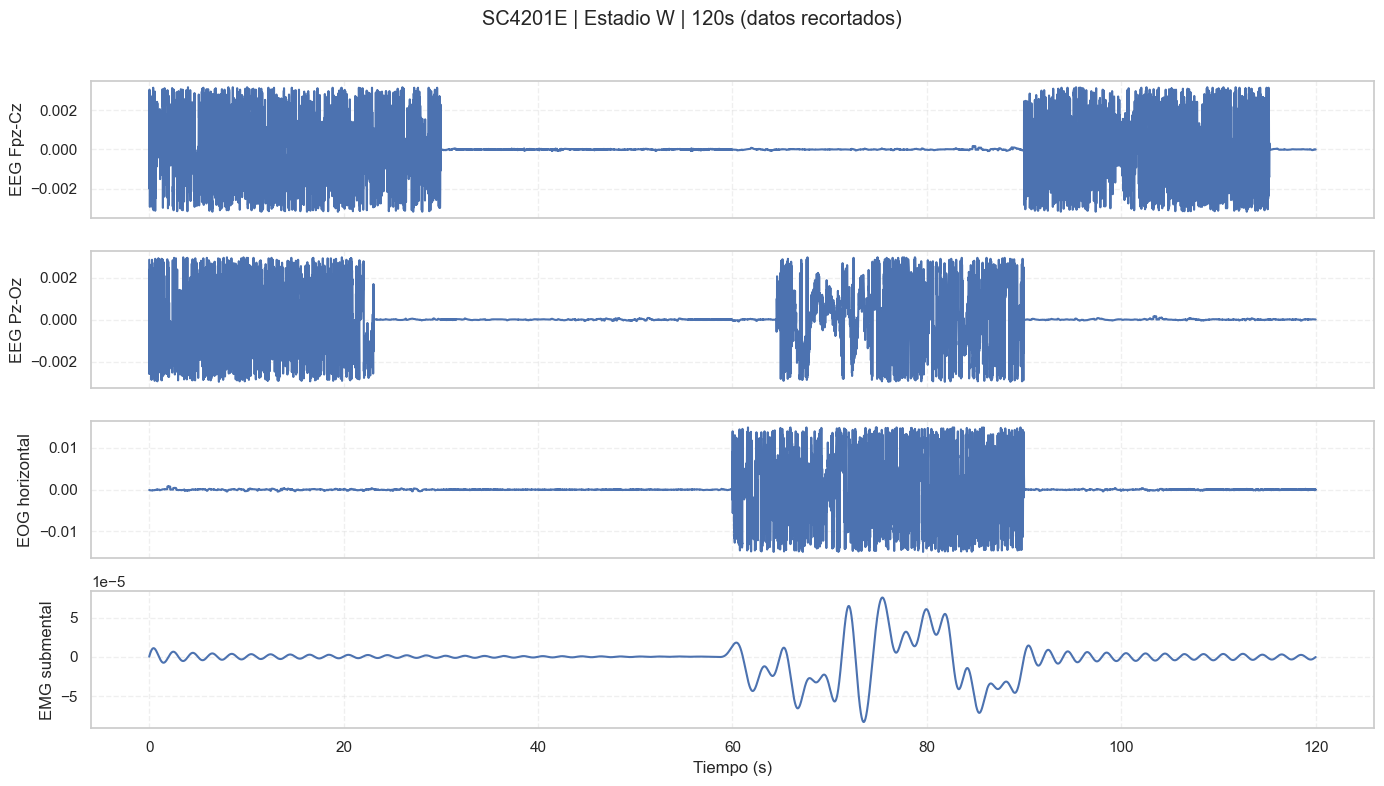

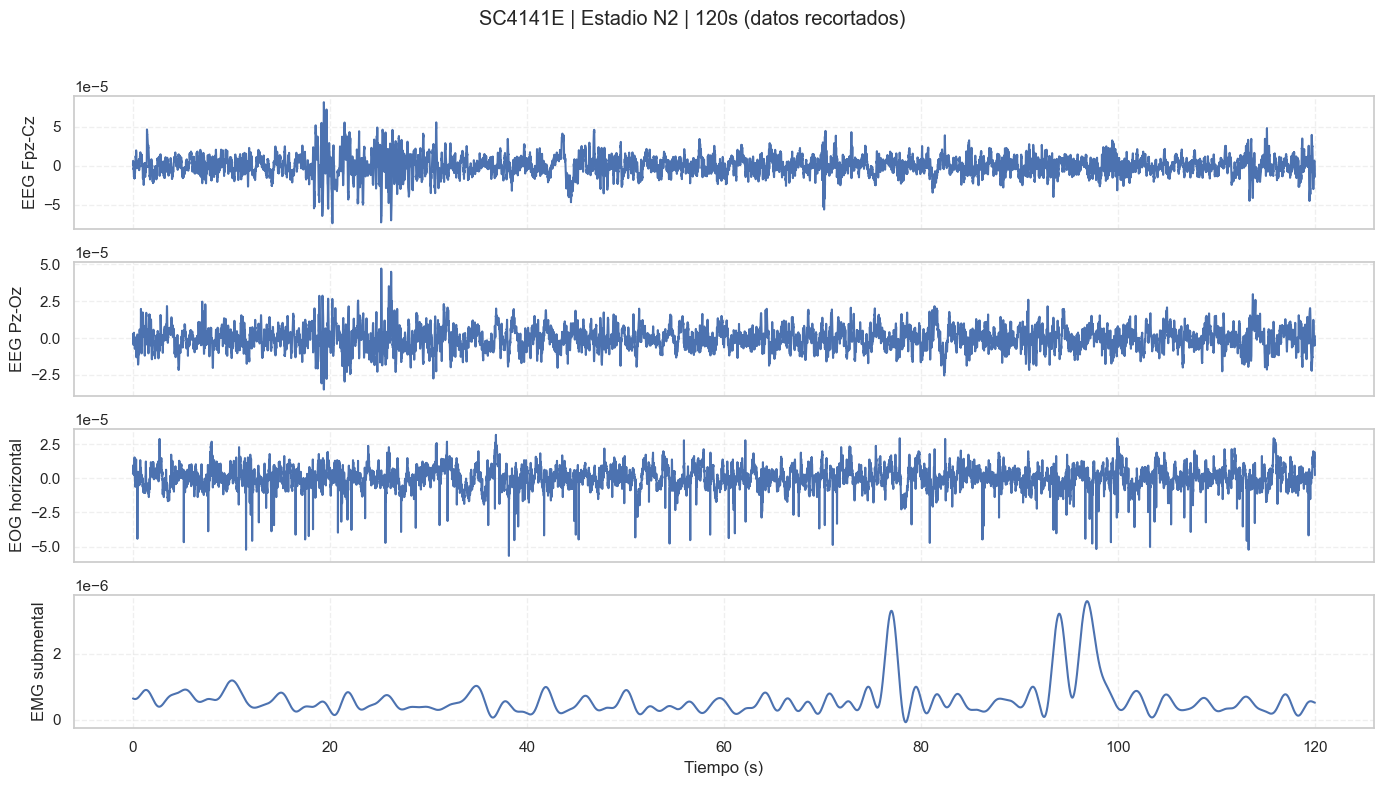

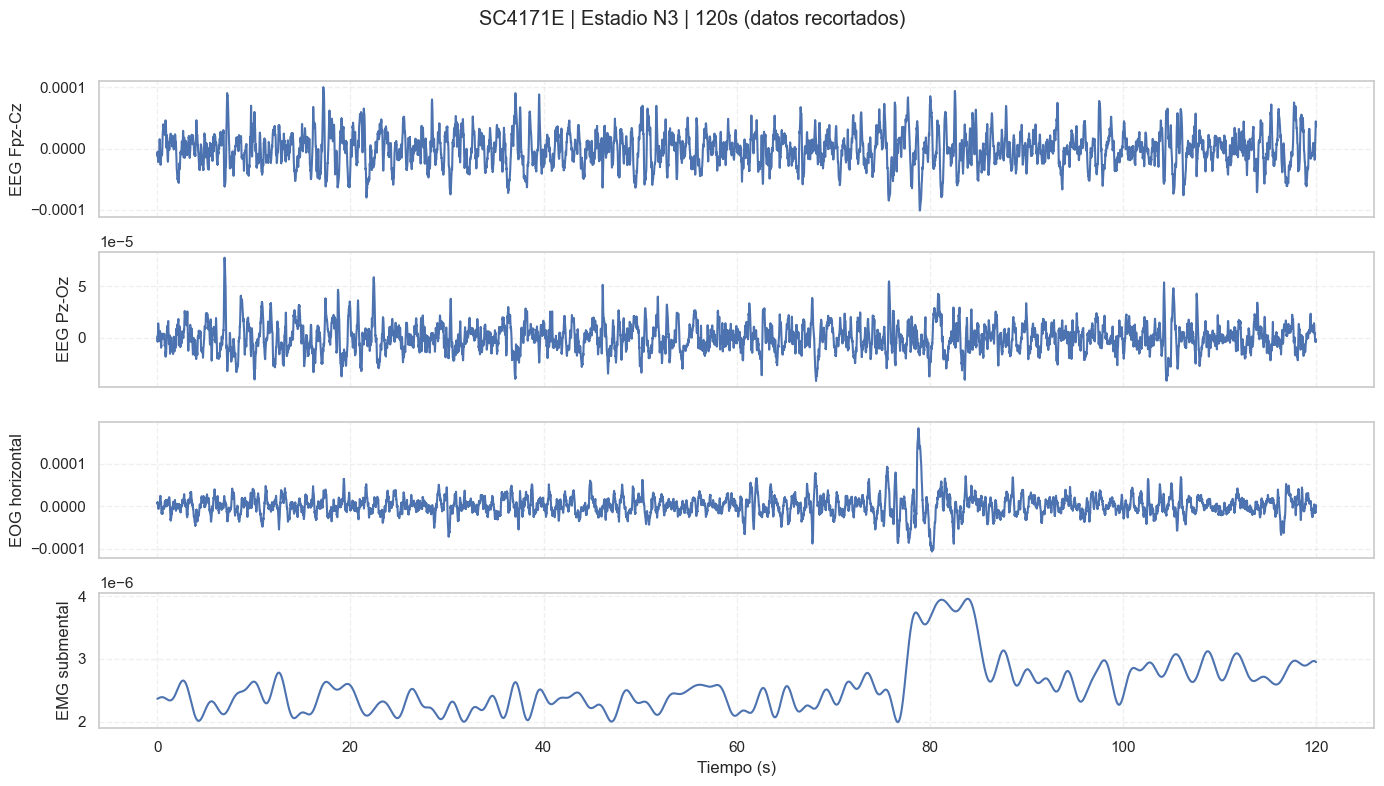

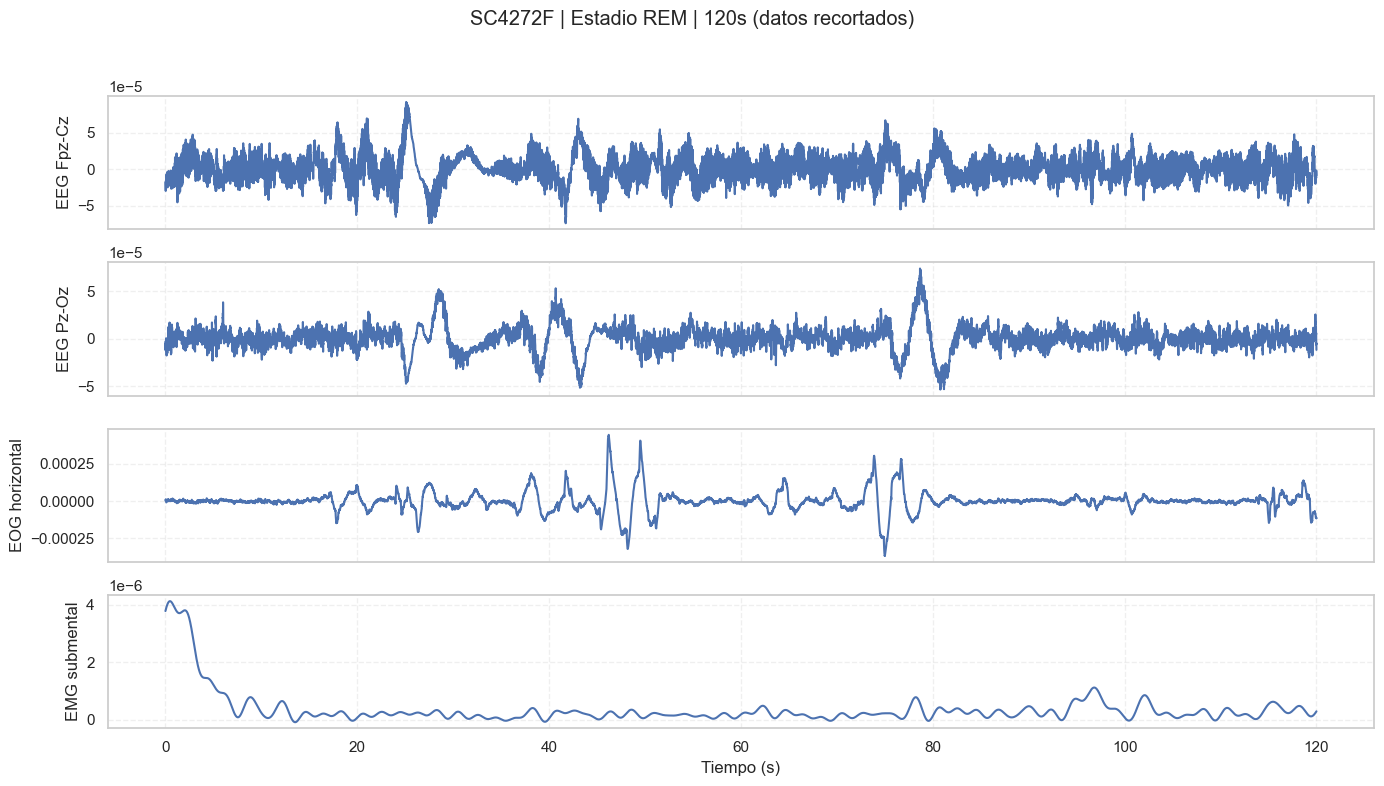

In [13]:
figures = []
for subject_id, stage in example_plan:
    try:
        fig = plot_trimmed_segment(subject_id, stage, duration=120.0)
        figures.append((subject_id, stage, fig))
    except Exception as exc:
        print(f"No se pudo generar segmento para {subject_id} - {stage}: {exc}")
figures

## 7. Observaciones
- La distribución W se reduce significativamente porque solo se mantiene una ventana de vigilia alrededor del periodo de sueño.
- La arquitectura resultante es más representativa del sueño nocturno (N2 predominante, REM/N3 en proporciones esperables).
- Los segmentos recortados permiten inspeccionar rápidamente actividades propias de cada estadio sin revisar horas de vigilia.